In [ ]:
import numpy as np
import gc
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def generate_random_dot_image(width, height, min_dots, max_dots, dot_size):
  num_dots = np.random.randint(min_dots, max_dots + 1)

  # Creates an array of the given shape filled with zeros (black)
  black_image = np.zeros((height, width), dtype=np.uint8)

  # Generate arrays of random x and y coordinates for the top-left corner of each dot
  random_x = np.random.randint(0, width - dot_size + 1, num_dots)
  random_y = np.random.randint(0, height - dot_size + 1, num_dots)

  # Iterates over each pair of (x, y) coordinates. For each dot, it sets a square region of the image (dot_size) to the pixel value 155
  # 155 corresponds to a mid-range gray on a scale of 0 (black) to 255 (white), so each dot will appear gray against the black background
  for x, y in zip(random_x, random_y):
    black_image[y:y + dot_size, x:x + dot_size] = 215

  # print(f"\nblack_image: {black_image}")

  return black_image

In [ ]:
def generate_random_rings_image(width, height, min_rings, max_rings, thicc):
    white_image = np.full((height, width), 255, dtype=np.uint8)  # White background

    center_x, center_y = width // 2, height // 2  # Center of the image

    # Randomly chooses the number of rings to generate
    num_rings = np.random.randint(min_rings, max_rings + 1)

    # Generates random radii for each ring, constrained between 1/20th and 1/3rd of the smaller dimension of the image, ensuring that rings fit within the image frame
    radii = np.random.randint(min(width, height) // 20, min(width, height) // 3, size=num_rings)

    # Sorts and then reverses the list of radii, so rings are drawn from the largest to the smallest. This ensures that smaller rings are not obscured by larger ones when drawn
    radii.sort()  # Sort radii in ascending order
    radii = radii[::-1]  # Reverse to start drawing from largest to smallest

    # Iterates over each radius, calculating the outer_radius and inner_radius of each ring. The inner radius is adjusted by the thicc parameter to create the thickness of the ring
    for radius in radii:
        outer_radius = radius
        inner_radius = max(outer_radius - thicc, 0)  # Ensure non-negative radius

        # Computes boolean masks for the outer and inner boundaries of each ring
        # The outer mask is where the circle pixels will be black, and the inner mask is where the circle pixels revert to white, forming the hollow part of each ring
        # Uses the masks to set the appropriate pixels in white_image. The outer ring area is set to black (0), and the inner ring area is set back to white (255), effectively drawing hollow rings
        y_indices, x_indices = np.ogrid[:height, :width]
        mask_outer = (x_indices - center_x)**2 + (y_indices - center_y)**2 <= outer_radius**2
        mask_inner = (x_indices - center_x)**2 + (y_indices - center_y)**2 < inner_radius**2

        white_image[mask_outer] = 0  # Black outer circle
        white_image[mask_inner] = 255  # White inner circle (hollow interior)

    return white_image

In [ ]:
def Plot(x, size, p, type = False):
    plt.figure(figsize=(10,size//5*2))
    for i in range(size):  # Display and save the first 5 separated images for rings and dots
      plt.subplot(size//5, 5, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      if type:
        plt.imshow(x[i], cmap=plt.cm.binary)
      else:
        plt.imshow(x[i], cmap='gray', vmin=0, vmax=1)
      #plt.imshow(x[i].reshape((height, width)), cmap='gray', vmin=0, vmax=255)
      plt.axis('off')
      plt.savefig(f"conv_separated_rings_image_{i}.png")
    plt.show()

In [ ]:
dataset_size = 500 # 1000 # 100
test_dataset_size = 200 # 20
width, height = 800, 800
# width, height = 200, 200 # reduce size from 800, 800
min_dots, max_dots = 20, 30
dot_size = 5
thicc = 5.5
# dot_size = 2 # 5 is original size for 800, 800
# thicc = 1 # 5.5 is the original thickness for 800, 800

dataset_dots = np.zeros((dataset_size, height, width), dtype=np.uint8) # black
dataset_rings = np.zeros((dataset_size, height, width), dtype=np.uint8) # black

test_dataset_dots = np.zeros((test_dataset_size, height, width), dtype=np.uint8) # black
test_dataset_rings = np.zeros((test_dataset_size, height, width), dtype=np.uint8) # black

In [ ]:
for i in range(dataset_size):
  random_dots_image = generate_random_dot_image(width, height, min_dots, max_dots, dot_size)
  dataset_dots[i] = random_dots_image # black image with grey dots (0 is black, 255 is white)

  random_ring_image = generate_random_rings_image(width, height, 1, 3, thicc)
  dataset_rings[i] = random_ring_image # white image with black rings (0 is black, 255 is white)

for i in range(test_dataset_size):
  random_dots_image = generate_random_dot_image(width, height, min_dots, max_dots, dot_size)
  test_dataset_dots[i] = random_dots_image # black image with grey dots (0 is black, 255 is white)

  random_ring_image = generate_random_rings_image(width, height, 1, 3, thicc)
  test_dataset_rings[i] = random_ring_image # white image with black rings (0 is black, 255 is white)

In [ ]:
# dataset_rings_normalized = 255 - dataset_rings # not necessary

dataset_rings_normalized = dataset_rings.astype(np.float16) / 255.0
dataset_dots = 255 - dataset_dots  # white image with grey dots
dataset_dots_normalized = dataset_dots.astype(np.float16) / 255.0

test_dataset_rings_normalized = test_dataset_rings.astype(np.float16) / 255.0
test_dataset_dots = 255 - test_dataset_dots  # white image with grey dots
test_dataset_dots_normalized = test_dataset_dots.astype(np.float16) / 255.0

In [ ]:
def overlay_images(base_image, overlay_image):
  # Where the overlay image is not white (255), overwrite the base image
  combined_image = np.where(overlay_image < 255, overlay_image, base_image)
  return combined_image

# Create a new dataset for the combined images
dataset_combined = np.zeros_like(dataset_dots)
test_dataset_combined = np.zeros_like(test_dataset_dots)

# Combine the dot and ring images
for i in range(dataset_size):
    dataset_combined[i] = overlay_images(dataset_dots[i], dataset_rings[i])

# Normalize and reshape the combined dataset
dataset_combined_norm = dataset_combined.astype('float16') / 255.0
# dataset_combined_reshaped = dataset_combined_norm.reshape((-1, height, width, 1))

# Combine the dot and ring images for tests
for i in range(test_dataset_size):
    test_dataset_combined[i] = overlay_images(test_dataset_dots[i], test_dataset_rings[i])

# Normalize and reshape the combined dataset
test_dataset_combined_norm = test_dataset_combined.astype('float16') / 255.0
# test_dataset_combined_reshaped = test_dataset_combined_norm.reshape((-1, height, width, 1))

In [ ]:
del dataset_combined, dataset_dots, dataset_rings, test_dataset_combined, test_dataset_dots, test_dataset_rings

# Manually invoke garbage collector
gc.collect()

0

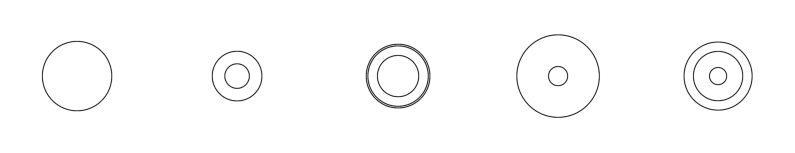

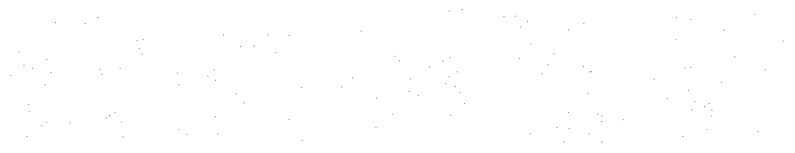

In [ ]:
# Visualize and save some of the separated images
Plot(dataset_rings_normalized, 5, None)
Plot(dataset_dots_normalized, 5, None)

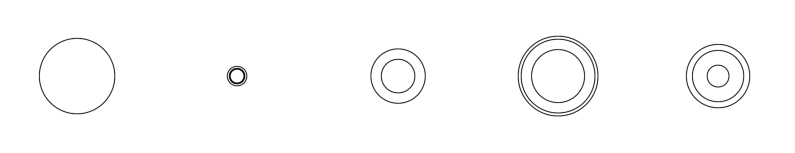

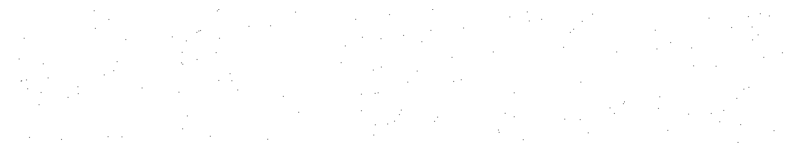

In [ ]:
# Visualize and save some of the separated images for test
Plot(test_dataset_rings_normalized, 5, None)
Plot(test_dataset_dots_normalized, 5, None)

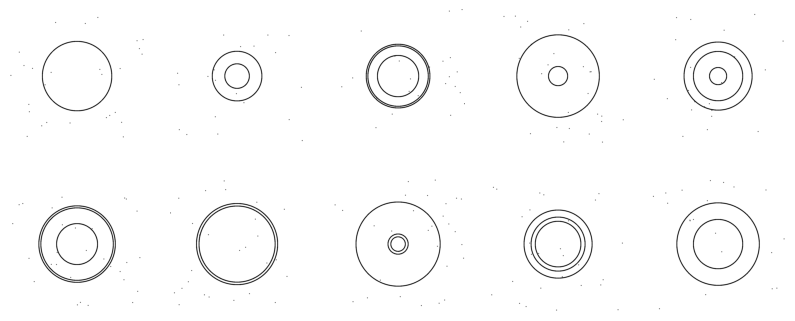

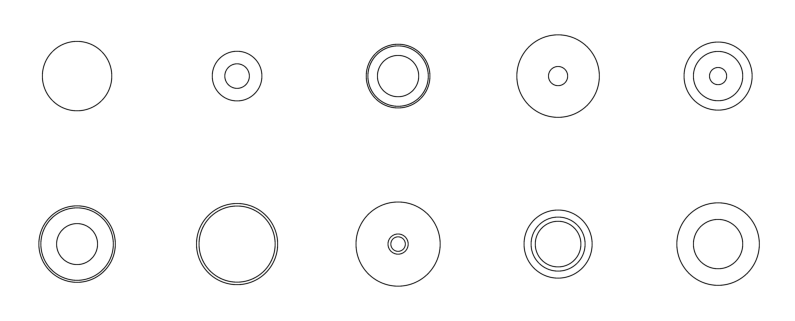

In [ ]:
# Display and save the first 10 combined images
Plot(dataset_combined_norm, 10, None)
Plot(dataset_rings_normalized, 10, None)

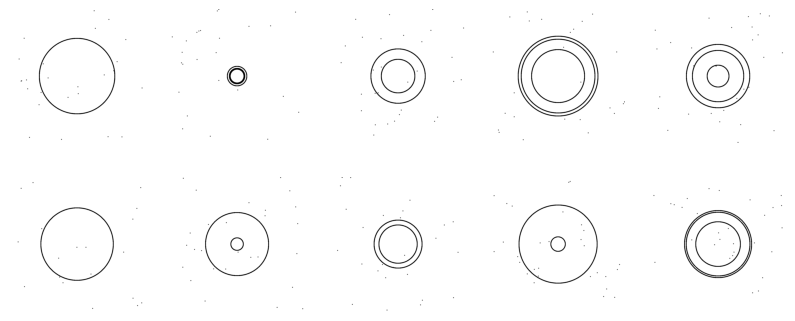

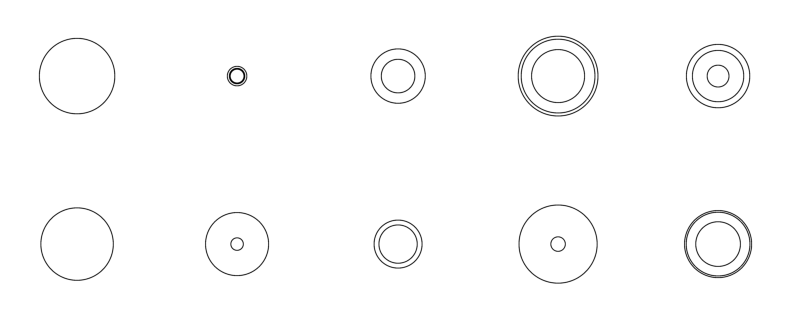

In [ ]:
# Display and save the first 10 combined images for test
Plot(test_dataset_combined_norm, 10, None)
Plot(test_dataset_rings_normalized, 10, None)

In [ ]:
# Convolutional Autoencoder architecture
input_img = Input(shape=(height, width, 1))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Training the autoencoder
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

autoencoder.fit(dataset_combined_norm.reshape((-1, height, width, 1)),    # input data with noise (rings+dots)
                dataset_rings_normalized.reshape((-1, height, width, 1)), # ouput data without noise (rings)
                epochs=50, # 50 complete pass through the entire training dataset
                batch_size=10, # 32 number of samples that will be propagated through the network in one forward/backward pass
                validation_data = (test_dataset_combined_norm.reshape((-1, height, width, 1)),
                                   test_dataset_rings_normalized.reshape((-1, height, width, 1))), # evaluate the model's performance at the end of each epoch
                callbacks=[early_stopping])

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - loss: 0.4432 - val_loss: 0.0525
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 121ms/step - loss: 0.0336 - val_loss: 0.0093
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - loss: 0.0081 - val_loss: 0.0062
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 135ms/step - loss: 0.0055 - val_loss: 0.0044
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 1

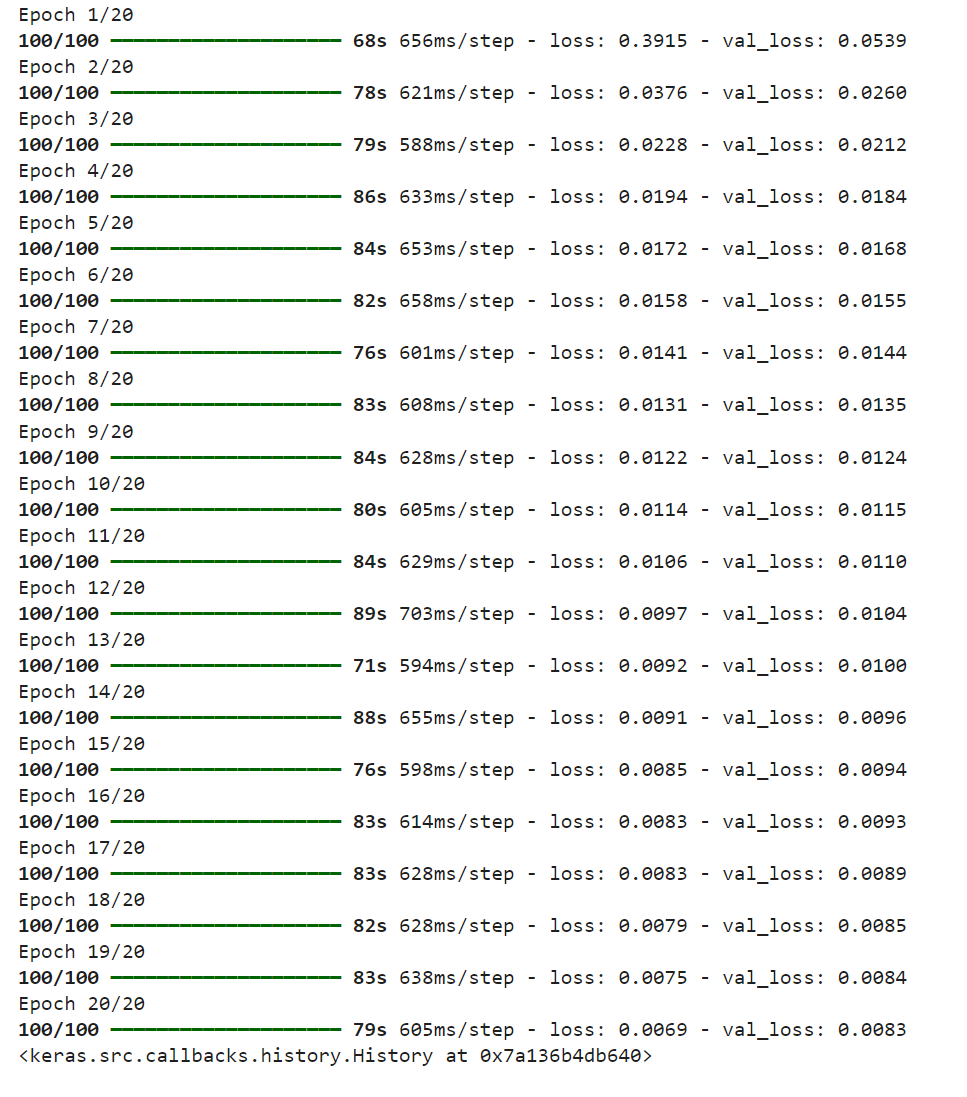


In [ ]:
# Use the trained autoencoder to decode the combined images
evaluation = autoencoder.evaluate(test_dataset_combined_norm.reshape((-1, height, width, 1)), test_dataset_rings_normalized.reshape((-1, height, width, 1)))
# evaluation = autoencoder.evaluate(test_dataset_combined_norm.reshape((-1, height, width, 1)), test_dataset_dots_normalized.reshape((-1, height, width, 1)))
print('Test Accuracy : {:.3f}'.format(evaluation))

# reconstruct the image without dots and only rings
predicted = autoencoder.predict(test_dataset_combined_norm.reshape((-1, height, width, 1)))

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 544ms/step - loss: 6.7802e-04
Test Accuracy : 0.001
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


200 x 200 image

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 701ms/step - loss: 0.0083

Test Accuracy : 0.008

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 452ms/step

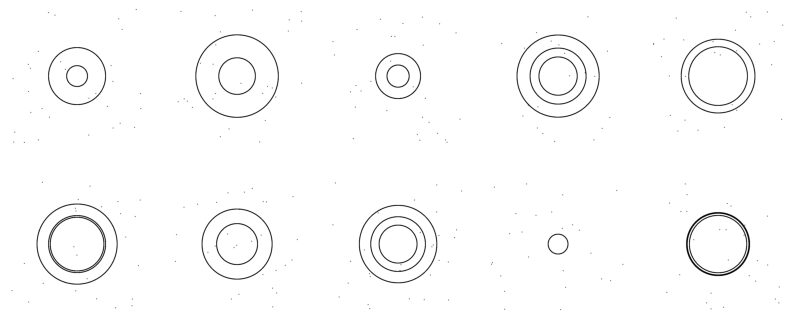

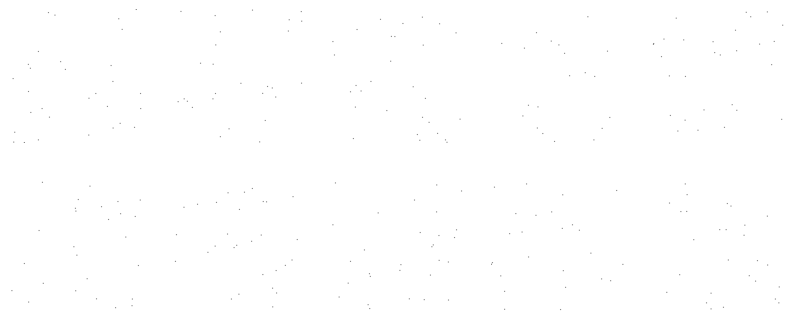

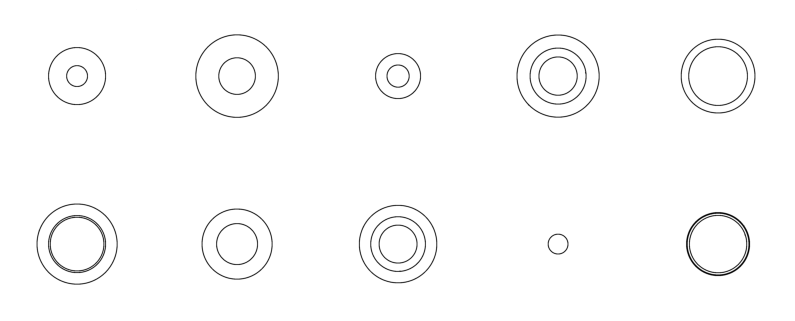

In [ ]:
# Visualize and save some of the separated images for 200x200 images
Plot(test_dataset_combined_norm, 10, None)
# Plot(test_dataset_rings_normalized, 10, None)
Plot(test_dataset_dots_normalized, 10, None)
Plot(predicted, 10, None)

test_dataset_combined_norm:  (200, 200, 200)
test_dataset_rings_normalized:  (200, 200, 200)
predicted:  (200, 200, 200, 1)
predicted_squeezed:  (200, 200, 200)
test_dataset_combined_norm - max: 1.0 min: 0.0 non-zeros: 39592
predicted_squeezed - max: 1.0 min: 0.002642046194523573 non-zeros: 40000
simulated_images_decoded - max: 1.0 min: 0.39215686274509803 non-zeros: 40000
simulated_images_decoded_alt - max: 1.0 min: 0.015205144882202148 non-zeros: 40000
Similarities between ground truth and autoencoder output
Number of similar pixels: 7920548
Number of dissimilar pixels: 79452
test_dataset_combined_norm - non-ones: 94
predicted_squeezed - non-ones: 797
simulated_images_decoded - non-ones: 94
simulated_images_decoded_alt - non-ones: 817


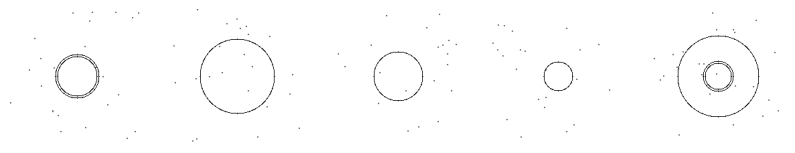

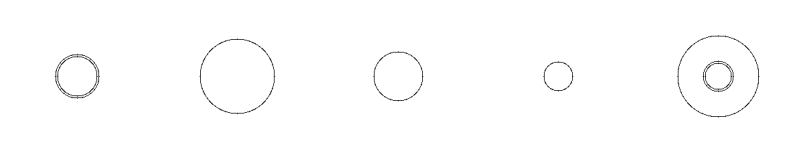

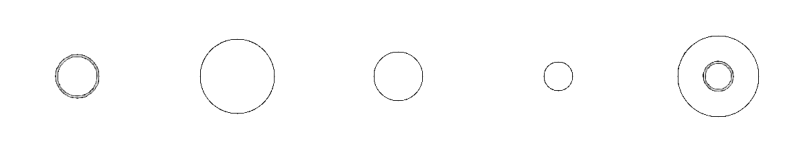

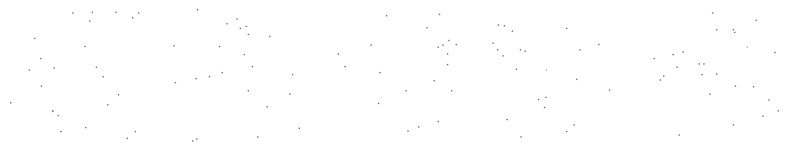

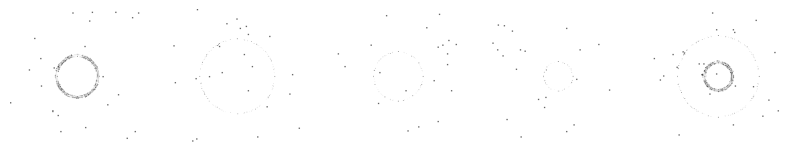

In [ ]:
# Separate the ring and dot images from the images_overaly for 200x200 images
print("test_dataset_combined_norm: ", test_dataset_combined_norm.shape)
print("test_dataset_rings_normalized: ", test_dataset_rings_normalized.shape)
print("predicted: ", predicted.shape) # shape (200, 200, 200, 1)
predicted_squeezed = np.squeeze(predicted)
print("predicted_squeezed: ", predicted_squeezed.shape)

# Separate the ring and dot images from the simulated test_dataset_combined_norm

# Approach 1: When dissimilar_mask is TRUE dots pixel color is chosen, else white color is chosen
similar_pixels = np.isclose(test_dataset_combined_norm, predicted_squeezed, atol=0.05)  # tolerance level 10% difference
dissimilar_mask = np.logical_not(similar_pixels)
simulated_images_decoded = np.where(dissimilar_mask, test_dataset_dots_normalized, 1)

# Approach 2: 1 - (ground truth - predicted)
difference = np.abs(test_dataset_combined_norm - predicted_squeezed)
toleranced_difference = np.where(difference < 0.05, 0, difference) # tolerance level 10% difference
simulated_images_decoded_alt = 1 - toleranced_difference

print(f"test_dataset_combined_norm - max: {np.max(test_dataset_combined_norm[0])} min: {np.min(test_dataset_combined_norm[0])} non-zeros: {np.count_nonzero(test_dataset_combined_norm[0])}")
print(f"predicted_squeezed - max: {np.max(predicted_squeezed[0])} min: {np.min(predicted_squeezed[0])} non-zeros: {np.count_nonzero(predicted_squeezed[0])}")
print(f"simulated_images_decoded - max: {np.max(simulated_images_decoded[0])} min: {np.min(simulated_images_decoded[0])} non-zeros: {np.count_nonzero(simulated_images_decoded[0])}")
print(f"simulated_images_decoded_alt - max: {np.max(simulated_images_decoded_alt[0])} min: {np.min(simulated_images_decoded_alt[0])} non-zeros: {np.count_nonzero(simulated_images_decoded_alt[0])}")

number_of_similar_pixels = np.count_nonzero(similar_pixels)
similar_indices = np.where(similar_pixels)
number_of_dissimilar_pixels = np.count_nonzero(dissimilar_mask)
dissimilar_indices = np.where(dissimilar_mask)
dissimilar_values_test = test_dataset_combined_norm[dissimilar_indices]
dissimilar_values_predicted = predicted_squeezed[dissimilar_indices]
print("Similarities between ground truth and autoencoder output")
print("Number of similar pixels:", number_of_similar_pixels)
print("Number of dissimilar pixels:", number_of_dissimilar_pixels)

not_close_to_one = np.logical_not(np.isclose(test_dataset_dots_normalized[0], 1, atol=0.05))
print(f"test_dataset_combined_norm - non-ones: {np.count_nonzero(not_close_to_one)}")
not_close_to_one = np.logical_not(np.isclose(predicted_squeezed[0], 1, atol=0.05))
print(f"predicted_squeezed - non-ones: {np.count_nonzero(not_close_to_one)}")
not_close_to_one = np.logical_not(np.isclose(simulated_images_decoded[0], 1, atol=0.05))
print(f"simulated_images_decoded - non-ones: {np.count_nonzero(not_close_to_one)}")
not_close_to_one = np.logical_not(np.isclose(simulated_images_decoded_alt[0], 1, atol=0.05))
print(f"simulated_images_decoded_alt - non-ones: {np.count_nonzero(not_close_to_one)}")

Plot(test_dataset_combined_norm, 5, None)
Plot(test_dataset_rings_normalized, 5, None)
Plot(predicted, 5, None)
Plot(simulated_images_decoded, 5, None)
Plot(simulated_images_decoded_alt, 5, None)

200x200 with 50 epochs - Epoch 50/50 using batch size 5

200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 323ms/step - loss: 0.0022 - val_loss: 0.0027

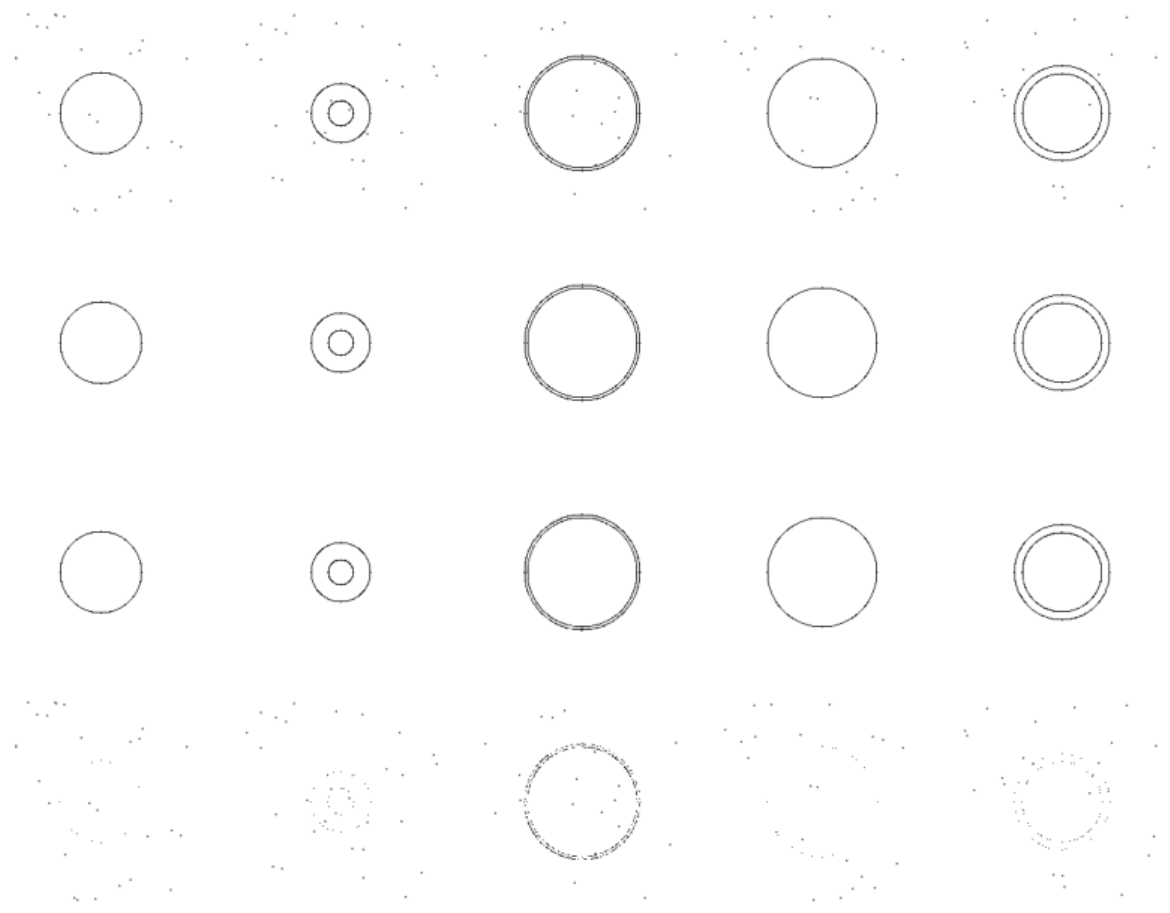

200x200 with 50 epochs - Epoch 50/50 using batch size 10.  Tested batch sizes 5, 10, 20, 30, 128, 256

100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 565ms/step - loss: 0.0041 - val_loss: 0.0044

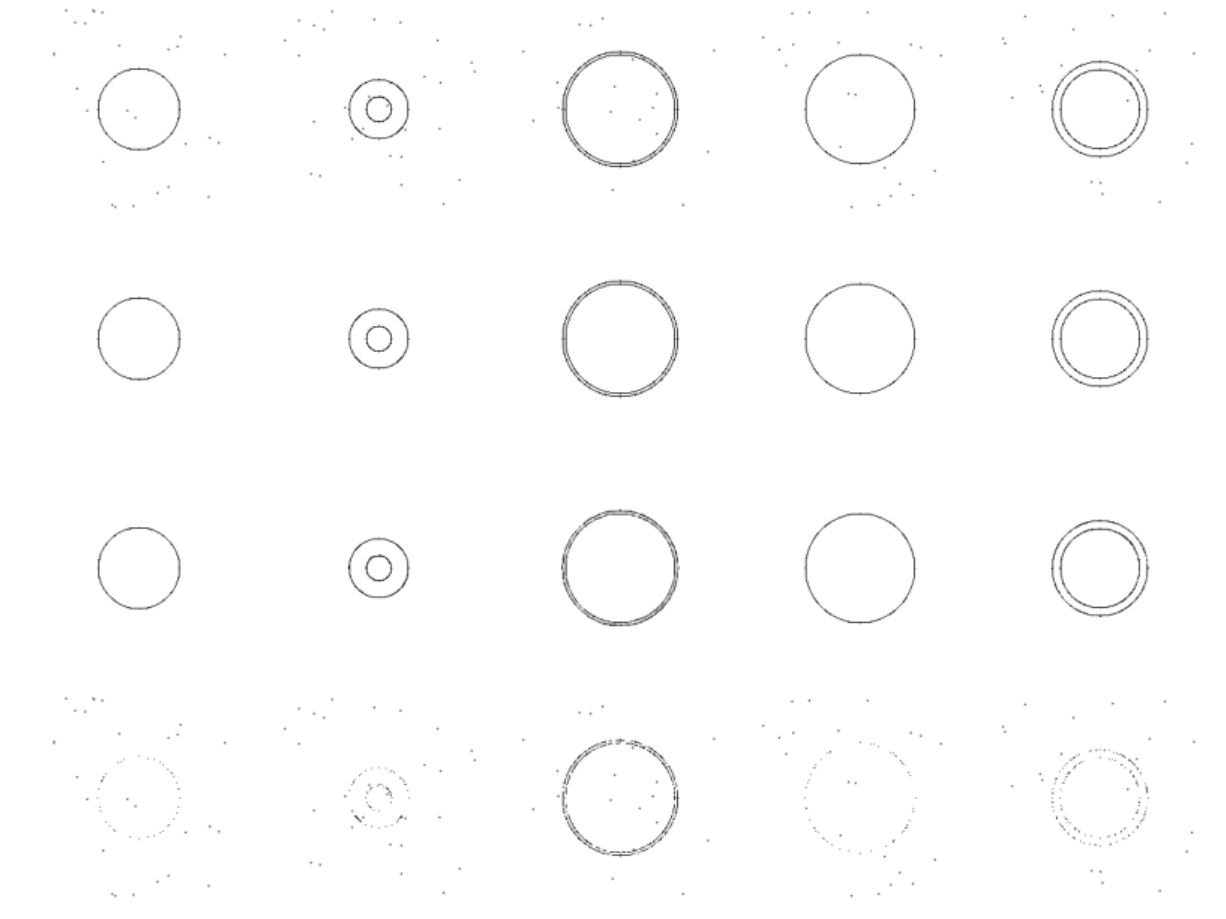

Modified plots 200x200 with 50 epochs, tolerance 0.05

test_dataset_combined_norm - max: 1.0 min: 0.0 non-zeros: 39592
predicted_squeezed - max: 1.0 min: 0.002642046194523573 non-zeros: 40000
simulated_images_decoded - max: 1.0 min: 0.39215686274509803 non-zeros: 40000
simulated_images_decoded_alt - max: 1.0 min: 0.015205144882202148 non-zeros: 40000
Similarities between ground truth and autoencoder output
Number of similar pixels: 7920548
Number of dissimilar pixels: 79452
test_dataset_combined_norm - non-ones: 94
predicted_squeezed - non-ones: 797
simulated_images_decoded - non-ones: 94
simulated_images_decoded_alt - non-ones: 817

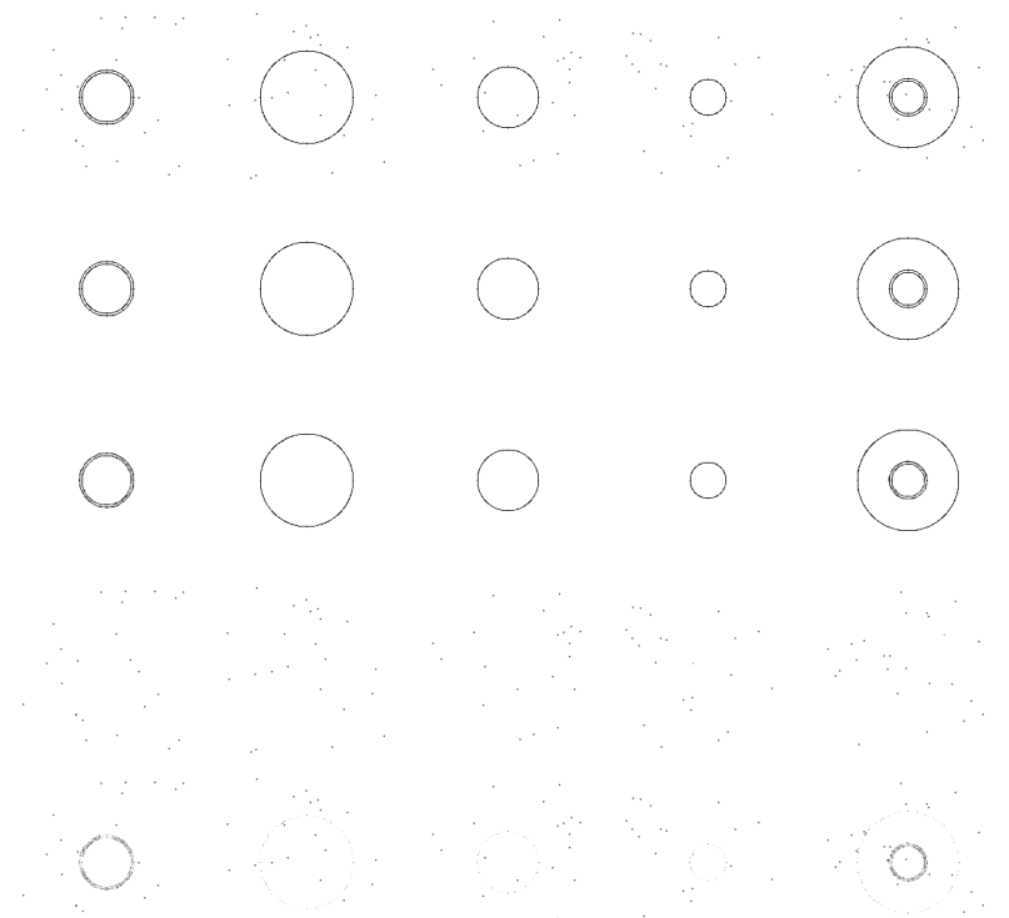

test_dataset_combined_norm:  (200, 800, 800)
test_dataset_rings_normalized:  (200, 800, 800)
predicted:  (200, 800, 800, 1)
predicted_squeezed:  (200, 800, 800)
test_dataset_combined_norm - max: 1.0 min: 0.0 non-zeros: 631652
predicted_squeezed - max: 1.0 min: 5.164352931092324e-17 non-zeros: 640000
simulated_images_decoded - max: 1.0 min: 0.1568603515625 non-zeros: 640000
simulated_images_decoded_alt - max: 1.0 min: 2.384185791015625e-05 non-zeros: 640000


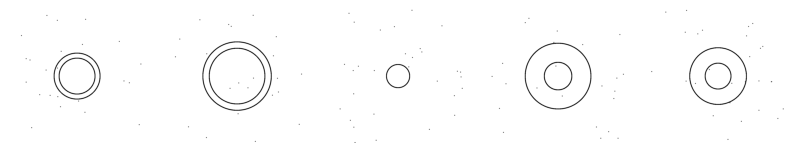

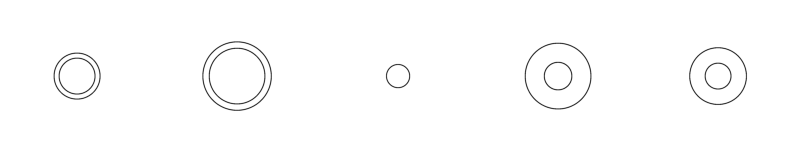

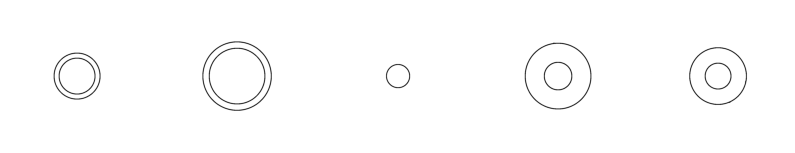

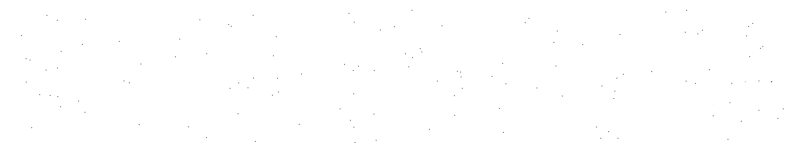

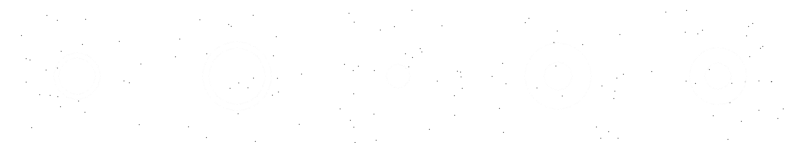

In [ ]:
# Separate the ring and dot images from the images_overaly for 800x800 images
print("test_dataset_combined_norm: ", test_dataset_combined_norm.shape)
print("test_dataset_rings_normalized: ", test_dataset_rings_normalized.shape)
print("predicted: ", predicted.shape) # shape (200, 200, 200, 1)
predicted_squeezed = np.squeeze(predicted)
print("predicted_squeezed: ", predicted_squeezed.shape)

# Separate the ring and dot images from the simulated test_dataset_combined_norm

# Approach 1: When dissimilar_mask is TRUE dots pixel color is chosen, else white color is chosen
similar_pixels = np.isclose(test_dataset_combined_norm, predicted_squeezed, atol=0.05)  # tolerance level 10% difference
dissimilar_mask = np.logical_not(similar_pixels)
simulated_images_decoded = np.where(dissimilar_mask, test_dataset_dots_normalized, 1)

# Approach 2: 1 - (ground truth - predicted)
difference = np.abs(test_dataset_combined_norm - predicted_squeezed)
toleranced_difference = np.where(difference < 0.05, 0, difference) # tolerance level 10% difference
simulated_images_decoded_alt = 1 - toleranced_difference

print(f"test_dataset_combined_norm - max: {np.max(test_dataset_combined_norm[0])} min: {np.min(test_dataset_combined_norm[0])} non-zeros: {np.count_nonzero(test_dataset_combined_norm[0])}")
print(f"predicted_squeezed - max: {np.max(predicted_squeezed[0])} min: {np.min(predicted_squeezed[0])} non-zeros: {np.count_nonzero(predicted_squeezed[0])}")
print(f"simulated_images_decoded - max: {np.max(simulated_images_decoded[0])} min: {np.min(simulated_images_decoded[0])} non-zeros: {np.count_nonzero(simulated_images_decoded[0])}")
print(f"simulated_images_decoded_alt - max: {np.max(simulated_images_decoded_alt[0])} min: {np.min(simulated_images_decoded_alt[0])} non-zeros: {np.count_nonzero(simulated_images_decoded_alt[0])}")

# number_of_similar_pixels = np.count_nonzero(similar_pixels)
# similar_indices = np.where(similar_pixels)
# number_of_dissimilar_pixels = np.count_nonzero(dissimilar_mask)
# dissimilar_indices = np.where(dissimilar_mask)
# dissimilar_values_test = test_dataset_combined_norm[dissimilar_indices]
# dissimilar_values_predicted = predicted_squeezed[dissimilar_indices]
# print("Similarities between ground truth and autoencoder output")
# print("Number of similar pixels:", number_of_similar_pixels)
# print("Number of dissimilar pixels:", number_of_dissimilar_pixels)

# not_close_to_one = np.logical_not(np.isclose(test_dataset_dots_normalized[0], 1, atol=0.05))
# print(f"test_dataset_combined_norm - non-ones: {np.count_nonzero(not_close_to_one)}")
# not_close_to_one = np.logical_not(np.isclose(predicted_squeezed[0], 1, atol=0.05))
# print(f"predicted_squeezed - non-ones: {np.count_nonzero(not_close_to_one)}")
# not_close_to_one = np.logical_not(np.isclose(simulated_images_decoded[0], 1, atol=0.05))
# print(f"simulated_images_decoded - non-ones: {np.count_nonzero(not_close_to_one)}")
# not_close_to_one = np.logical_not(np.isclose(simulated_images_decoded_alt[0], 1, atol=0.05))
# print(f"simulated_images_decoded_alt - non-ones: {np.count_nonzero(not_close_to_one)}")

Plot(test_dataset_combined_norm, 5, None)
Plot(test_dataset_rings_normalized, 5, None)
Plot(predicted, 5, None)
Plot(simulated_images_decoded, 5, None)
Plot(simulated_images_decoded_alt, 5, None)

predicted:  (200, 400, 400, 1)
predicted_squeezed:  (200, 400, 400)
test_dataset_combined_norm - max: 1.0 min: 0.0 non-zeros: 158908
predicted_squeezed - max: 1.0 min: 1.5539570085820742e-05 non-zeros: 160000
simulated_images_decoded - max: 1.0 min: 0.39215686274509803 non-zeros: 160000
simulated_images_decoded_alt - max: 1.0 min: 0.0009305477142333984 non-zeros: 160000
Similarities between ground truth and autoencoder output
Number of similar pixels: 31861888
Number of dissimilar pixels: 138112
test_dataset_combined_norm - non-ones: 120
predicted_squeezed - non-ones: 1298
simulated_images_decoded - non-ones: 117
simulated_images_decoded_alt - non-ones: 680

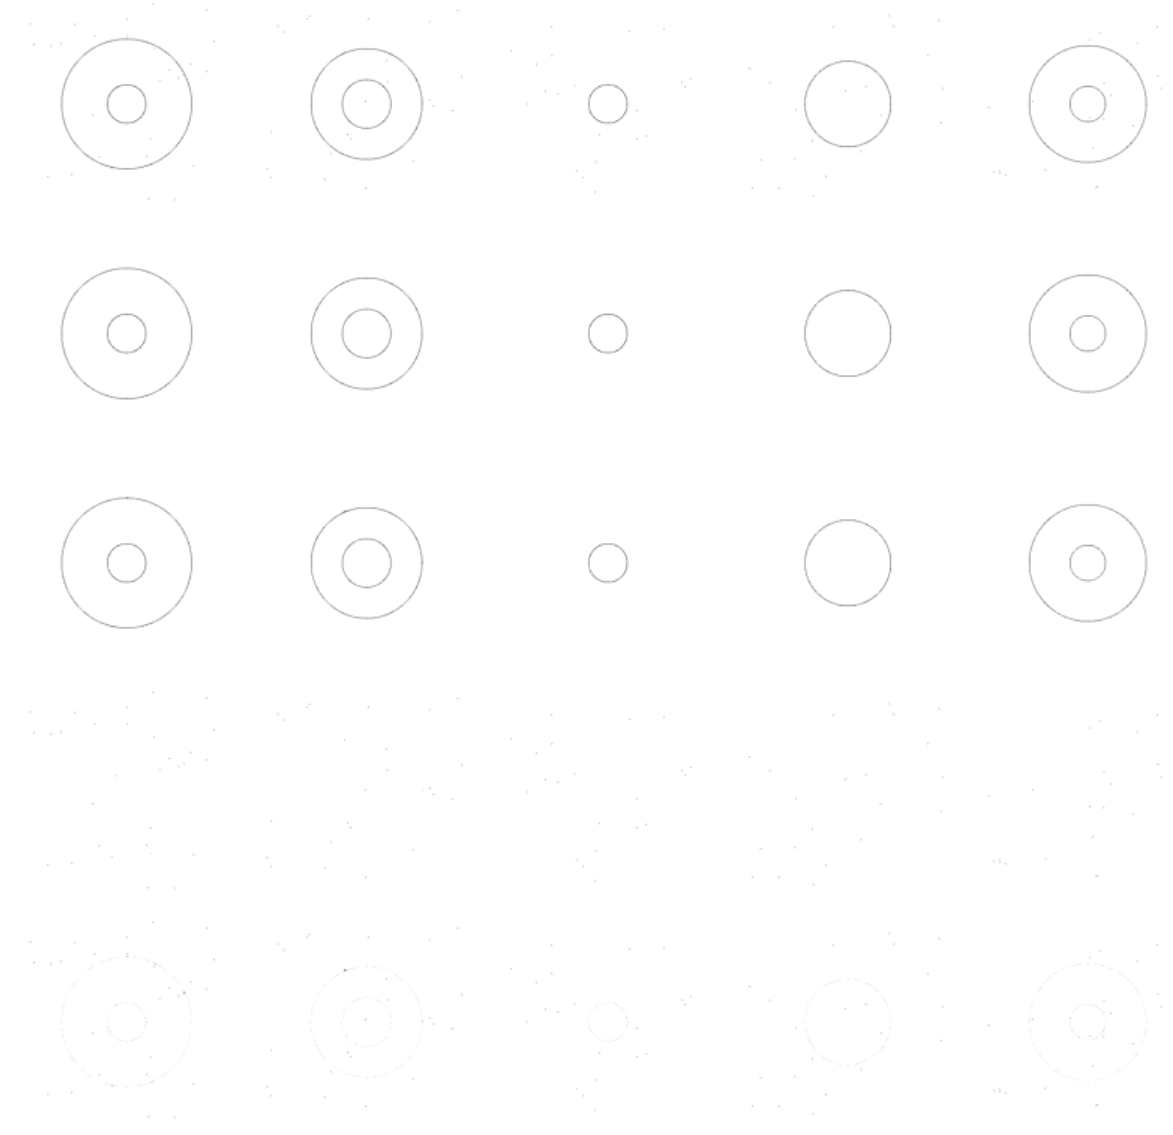

test_dataset_combined_norm:  (200, 800, 800)
test_dataset_rings_normalized:  (200, 800, 800)
predicted:  (200, 800, 800, 1)
predicted_squeezed:  (200, 800, 800)
test_dataset_combined_norm - max: 1.0 min: 0.0 non-zeros: 631652
predicted_squeezed - max: 1.0 min: 5.164352931092324e-17 non-zeros: 640000
simulated_images_decoded - max: 1.0 min: 0.1568603515625 non-zeros: 640000
simulated_images_decoded_alt - max: 1.0 min: 2.384185791015625e-05 non-zeros: 640000

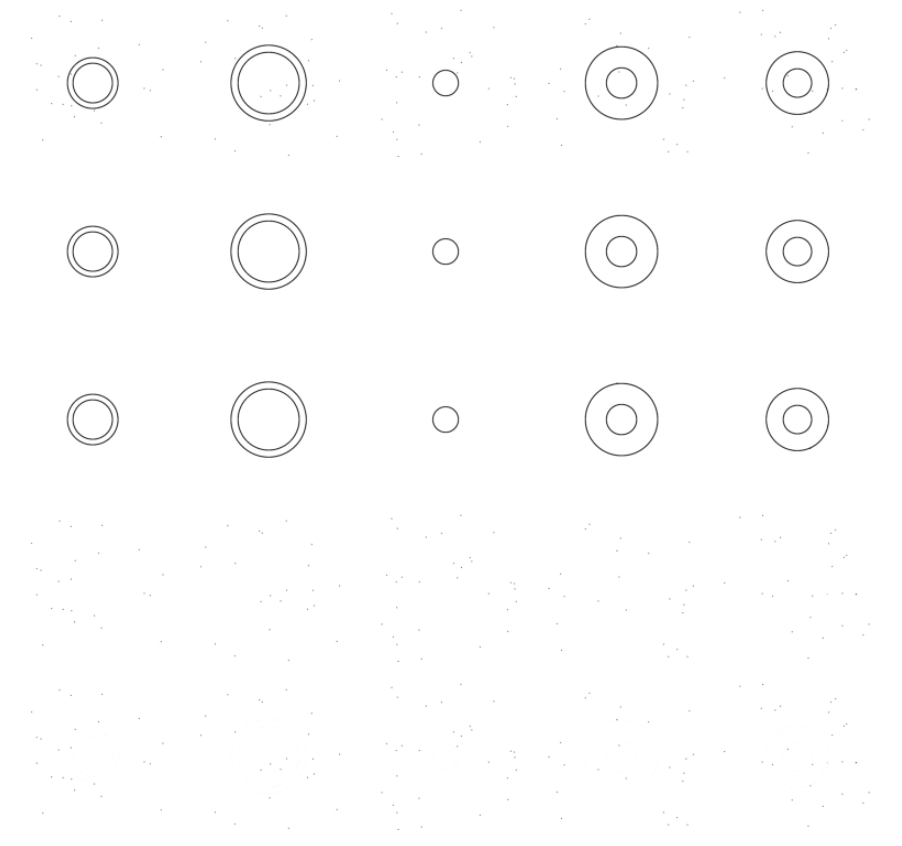
